<a href="https://colab.research.google.com/github/nvisagan/DS-Unit-2-Regression-Classification/blob/master/module3/DS7_lesson_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Regression & Classification, Module 3
- Make visualizations to explore relationships between features and target
- Do feature selection
- Do one-hot encoding of categorical features


### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Make visualizations to explore relationships between features and target

## Overview

Let's start with some example solutions from yesterday's assingment.

First, load data & remove outliers:

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

Do train/test split

- Use data from April & May 2016 to train
- Use data from June 2016 to test

In [4]:
# Convert to datetime and look at the date range
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: created, dtype: object

In [5]:
# There are 16217 + 15627 observations in April & May 2016,
# and 16973 observations in June 2016.
df['created'].dt.month.value_counts()

6    16973
4    16217
5    15627
Name: created, dtype: int64

In [6]:
# There are many ways to do train/test split based on date.
# Here's one way:
train = df[df.created.dt.month < 6]
test  = df[df.created.dt.month == 6]
train.shape, test.shape

((31844, 34), (16973, 34))

In [7]:
# Here's another way
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]
train.shape, test.shape

((31844, 34), (16973, 34))

In [8]:
# Here's another way
df = df.set_index('created')
train = df[:'2016-05'].reset_index()
test  = df['2016-06':].reset_index()
df = df.reset_index()
train.shape, test.shape

((31844, 34), (16973, 34))

## Follow Along


"Location, Location, Location" is a real estate slogan.

Let's explore the relationship between location & price.

In [9]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='price')

In [10]:
px.scatter(train, x='longitude', y='price', trendline='ols', opacity=0.05)

In [0]:
train['longitude_binned'] = (train['longitude']> -74.015) & (train['longitude']< -73.94)

In [12]:
train.groupby('longitude_binned').price.describe()

count         mean          std  ...     50%     75%      max
longitude_binned                                     ...                         
False              2876.0  2409.399861   983.869073  ...  2200.0  2700.0  12000.0
True              28968.0  3691.387048  1780.142461  ...  3235.0  4250.0  15500.0

[2 rows x 8 columns]

In [13]:
px.scatter(train, x='latitude', y='price', trendline='ols', opacity=0.05)

In [14]:
# Cluster the locations?
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, n_jobs=-1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
px.scatter(train, x='longitude', y='latitude', color='cluster')

In [15]:
train.groupby('cluster').price.describe()

count         mean          std  ...     50%      75%      max
cluster                                    ...                          
0        3224.0  3873.234801  1488.172103  ...  3495.0  4500.00  15000.0
1        2680.0  3804.895522  1971.634784  ...  3250.0  4325.00  15000.0
2         331.0  1909.090634   464.975787  ...  1825.0  2150.00   4225.0
3         328.0  2130.945122   645.000754  ...  1995.0  2331.25   5800.0
4         405.0  2066.313580   538.847783  ...  1900.0  2275.00   4350.0
5        3316.0  3531.368818  1207.847930  ...  3250.0  4003.75  15000.0
6         577.0  2301.632582   655.637323  ...  2195.0  2700.00   5000.0
7        2917.0  4005.230031  1725.322319  ...  3500.0  4500.00  15000.0
8         689.0  2519.178520   703.602455  ...  2400.0  2950.00   7385.0
9        3747.0  3864.677876  1445.443573  ...  3450.0  4600.00  15000.0
10       1824.0  3867.217105  1933.676474  ...  3300.0  4300.00  15500.0
11       4470.0  3366.052349  2053.506719  ...  2750.0  3600.00  15000.0
12        474.0  3204.071730  1047.363192  ...  2950.0  3553.00   9100.0
13       1702.0  4202.146886  2499.797100  ...  3335.0  4686.25  15500.0
14       1002.0  3009.686627  1049.746008  ...  2800.0  3400.00  14500.0
15        166.0  2017.283133   662.518362  ...  1999.0  2200.00   6772.0
16       1033.0  2369.537270   733.930482  ...  2150.0  2750.00   6895.0
17       2489.0  4194.940538  1981.067230  ...  3699.0  4925.00  15500.0
18        448.0  2271.464286   596.558256  ...  2100.0  2600.00   6138.0
19         22.0  1974.454545   357.224450  ...  1900.0  2100.00   2849.0

[20 rows x 8 columns]

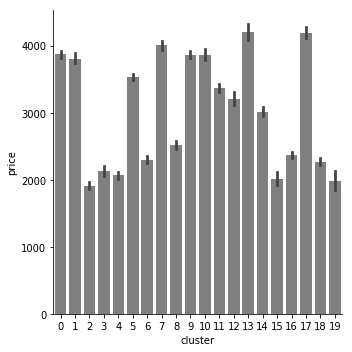

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x='cluster', y='price', data=train, kind='bar', color='grey');

### Advice

Do exploratory visualization for predictive modeling. Visualize the relationships between feature(s) and target.

Do this with your training set, after splitting your data. 

Try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

Try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features.

Seaborn is nice because it includes confidence intervals to visualize uncertainty.

In [17]:
# Explore bathrooms ...
train['bathrooms'].value_counts()

1.0     25507
2.0      5001
3.0       455
1.5       411
0.0       191
2.5       181
4.0        62
3.5        28
4.5         5
5.0         2
10.0        1
Name: bathrooms, dtype: int64

In [18]:
train.groupby('bathrooms').price.describe()

count          mean          std  ...      50%       75%      max
bathrooms                                      ...                            
0.0          191.0   3373.109948  2053.518599  ...   2750.0   3372.50  15000.0
1.0        25507.0   3035.404281   975.887086  ...   2900.0   3500.00  15500.0
1.5          411.0   4181.374696  1297.611957  ...   4105.0   4825.00  12000.0
2.0         5001.0   5442.525295  1789.672550  ...   5195.0   6200.00  15500.0
2.5          181.0   8292.370166  2973.460945  ...   7845.0  10000.00  15500.0
3.0          455.0   9518.182418  3214.857649  ...   9635.0  12000.00  15000.0
3.5           28.0  11928.892857  2750.821875  ...  12700.0  14248.75  15000.0
4.0           62.0   9673.354839  2910.605644  ...  10000.0  12000.00  15500.0
4.5            5.0  11910.000000  5550.045045  ...  14000.0  15000.00  15000.0
5.0            2.0  14000.000000   707.106781  ...  14000.0  14250.00  14500.0
10.0           1.0   3600.000000          NaN  ...   3600.0   3600.00   3600.0

[11 rows x 8 columns]

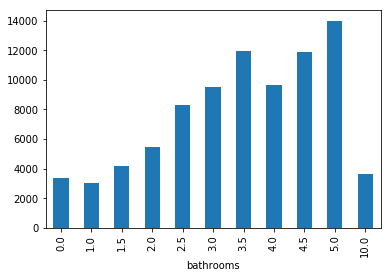

In [19]:
train.groupby('bathrooms').price.mean().plot.bar();

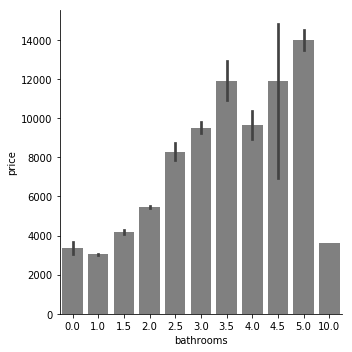

In [20]:
sns.catplot(x='bathrooms', y='price', data=train, kind='bar', color='grey');

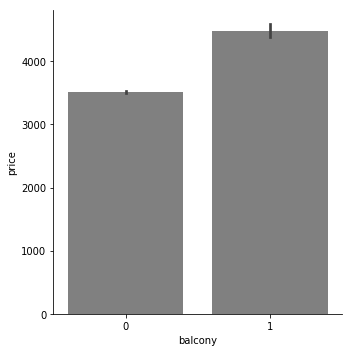

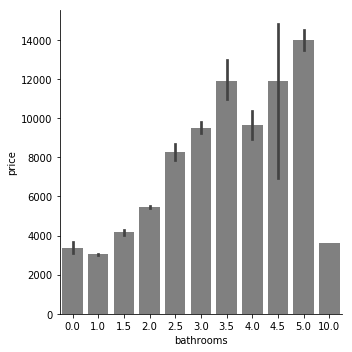

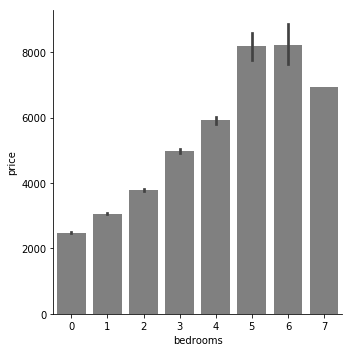

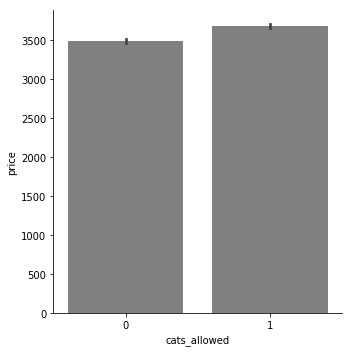

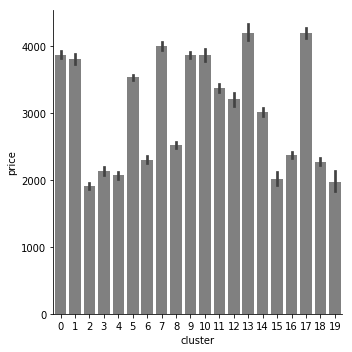

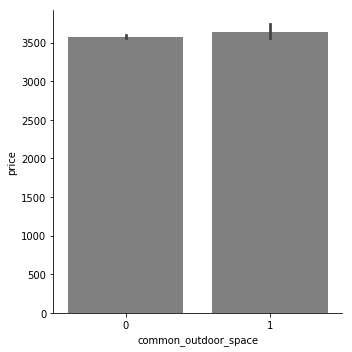

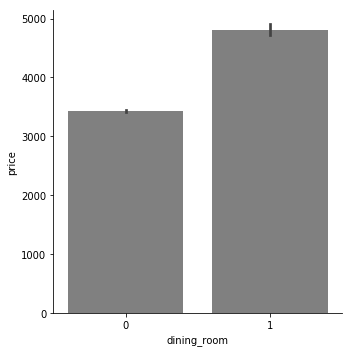

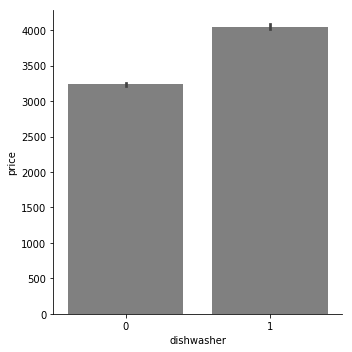

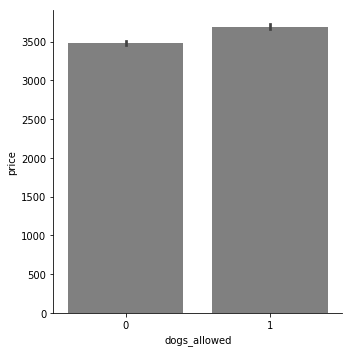

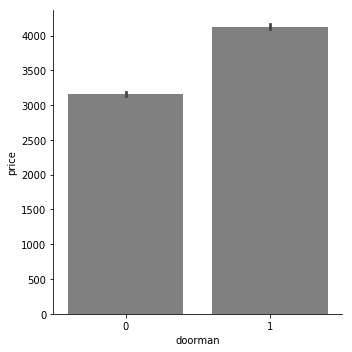

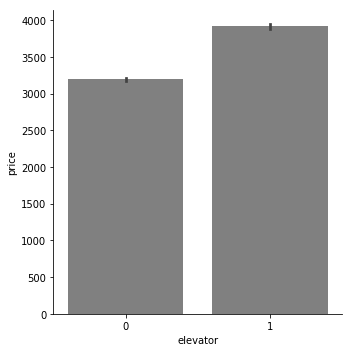

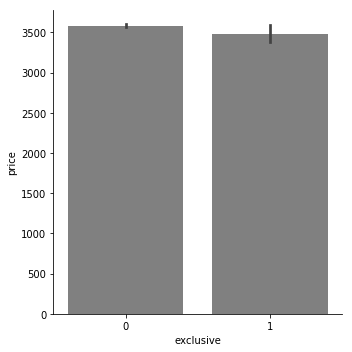

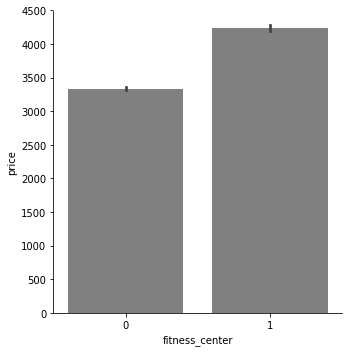

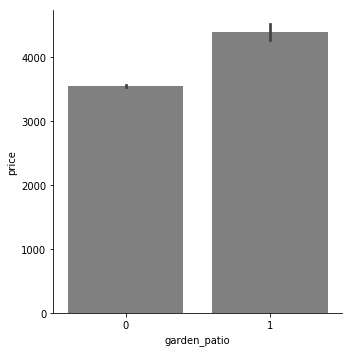

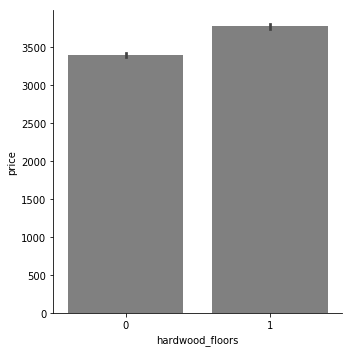

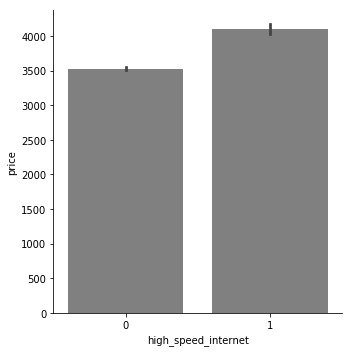

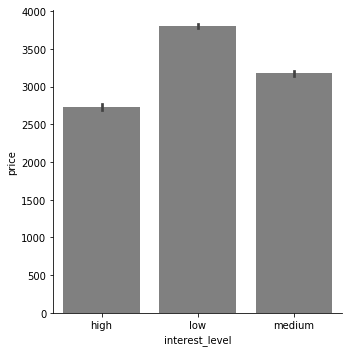

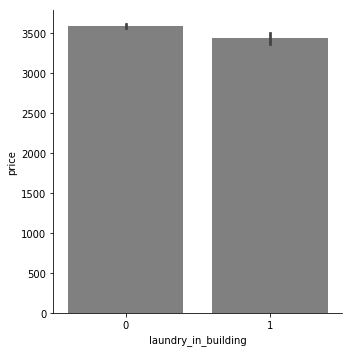

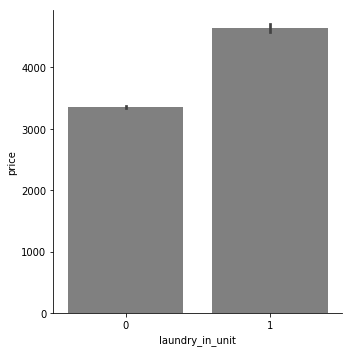

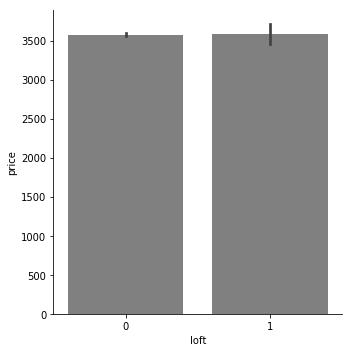

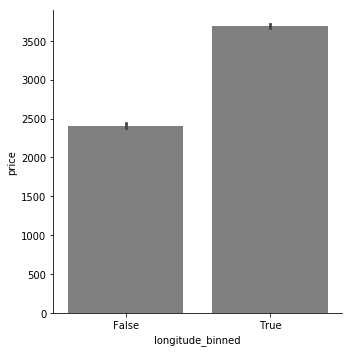

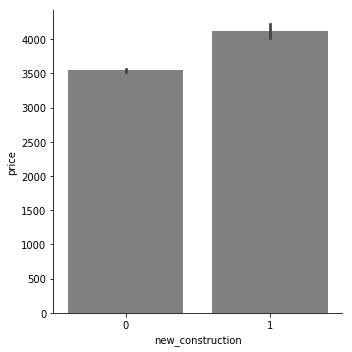

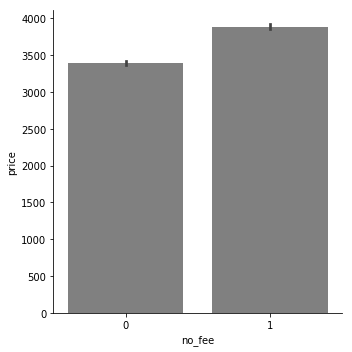

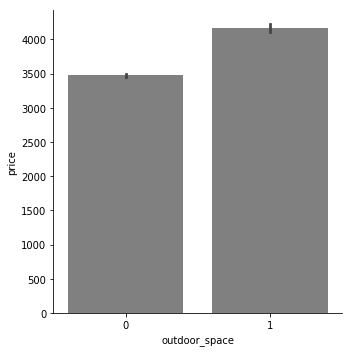

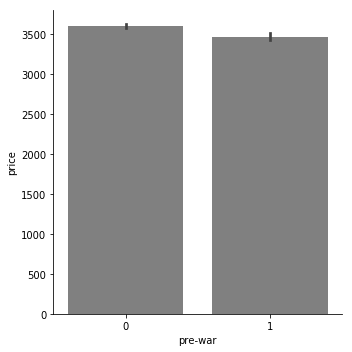

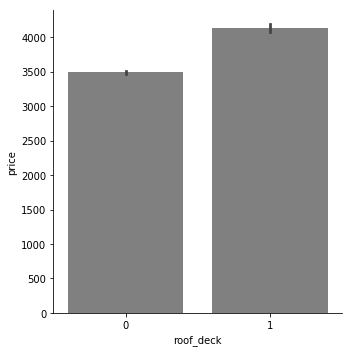

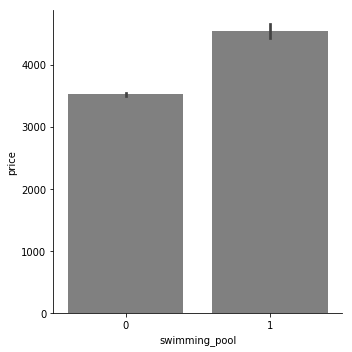

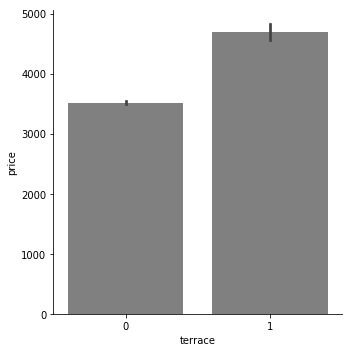

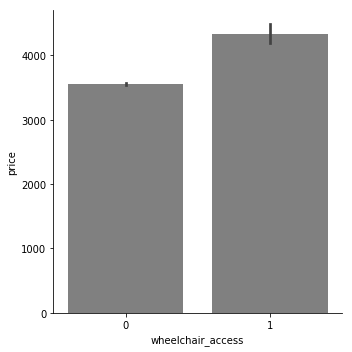

In [21]:
for col in sorted(train.columns):
    # Check how many unique values the column has first ...
    if train[col].nunique() <= 20:
        sns.catplot(x=col, y='price', data=train, kind='bar', color='grey')
        plt.show()

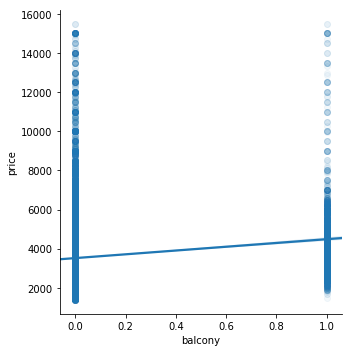

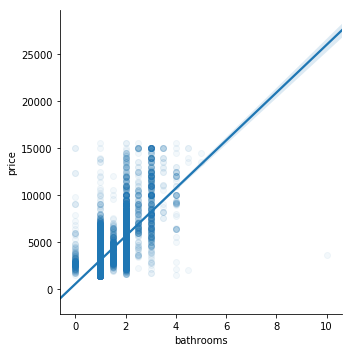

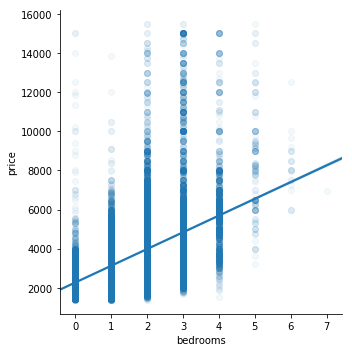

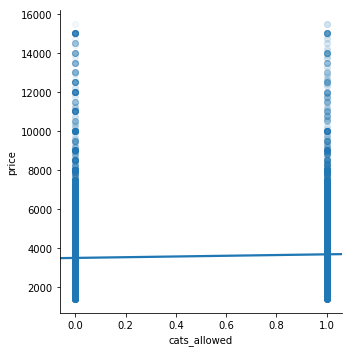

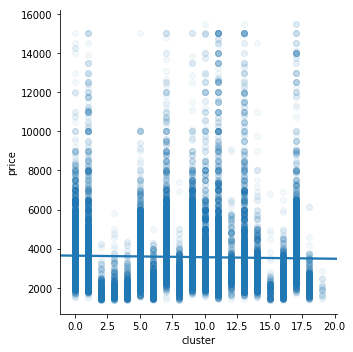

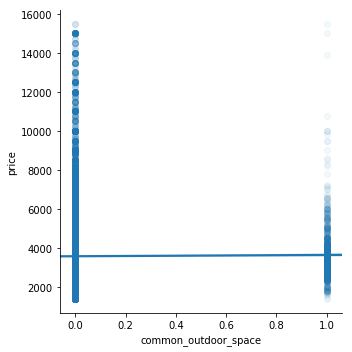

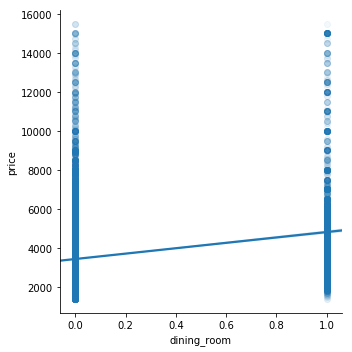

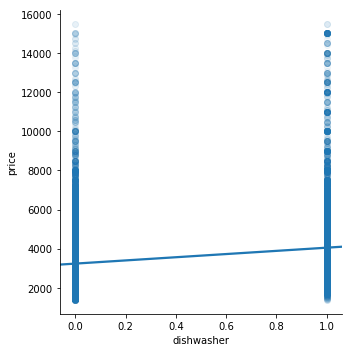

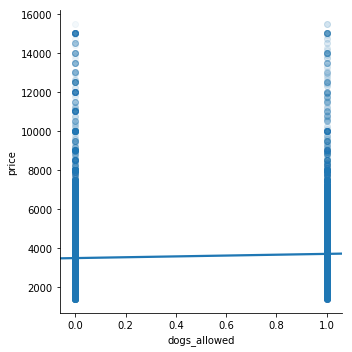

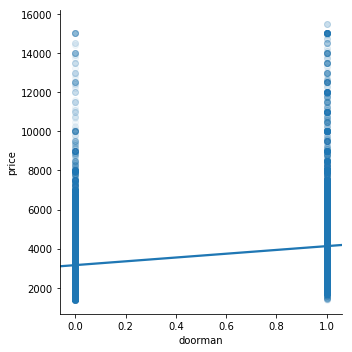

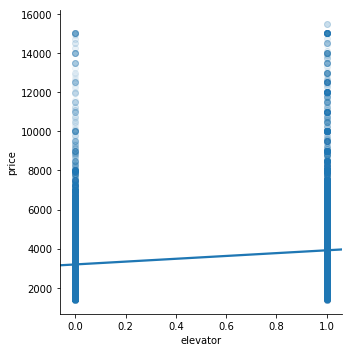

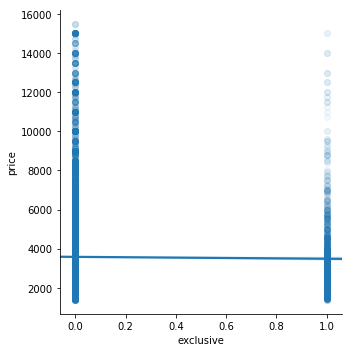

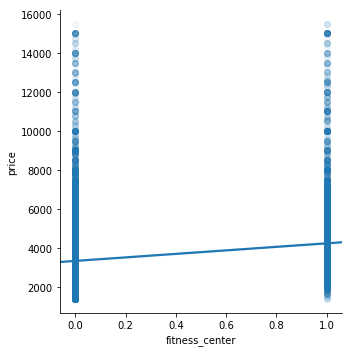

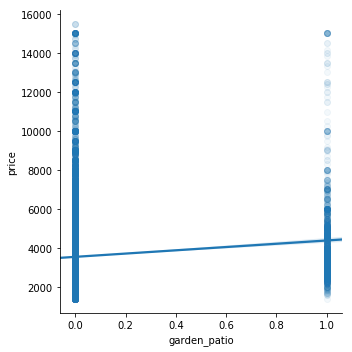

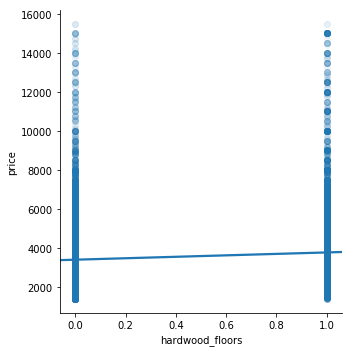

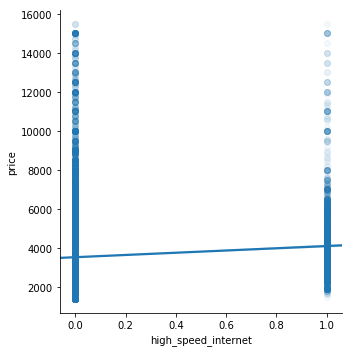

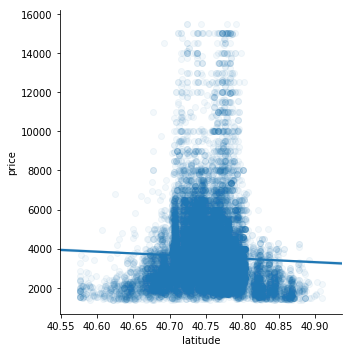

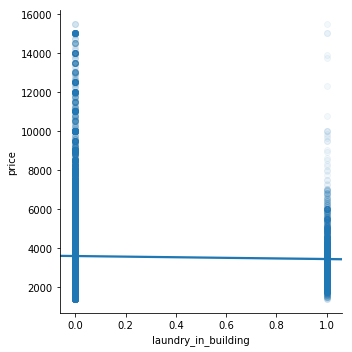

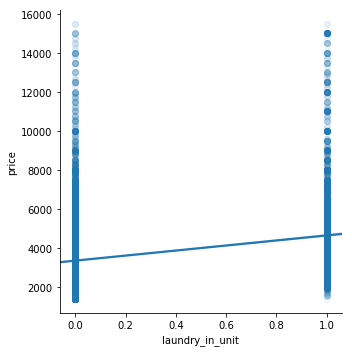

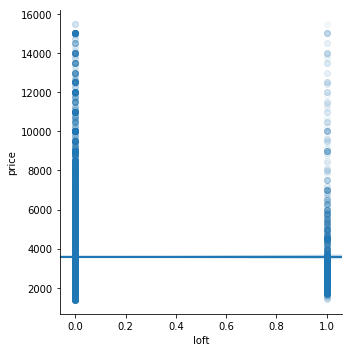

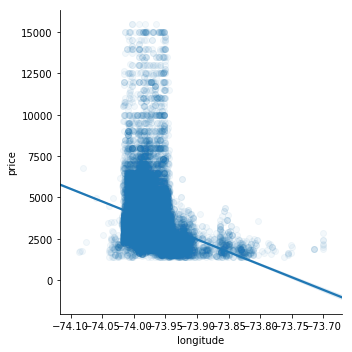

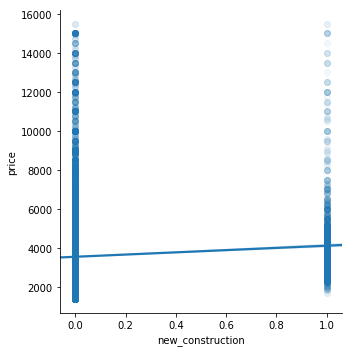

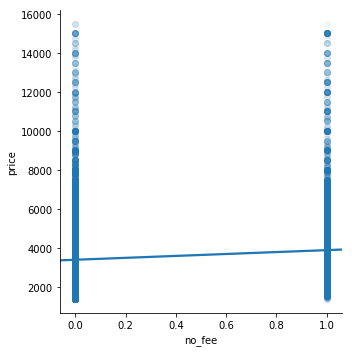

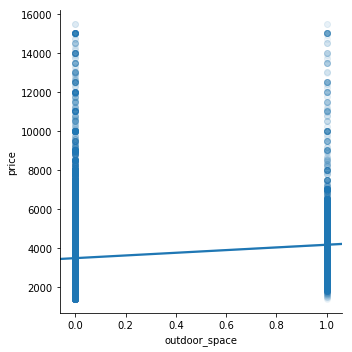

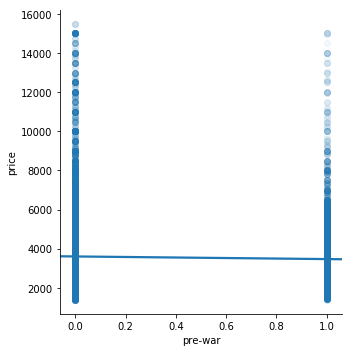

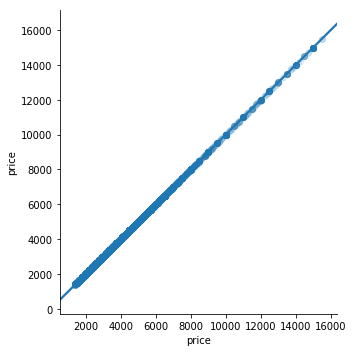

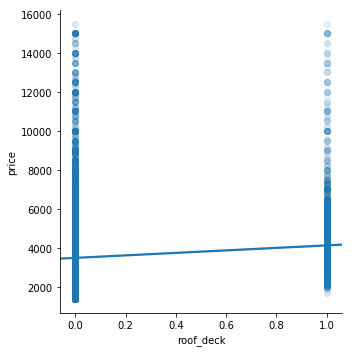

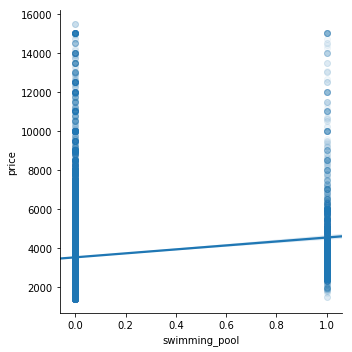

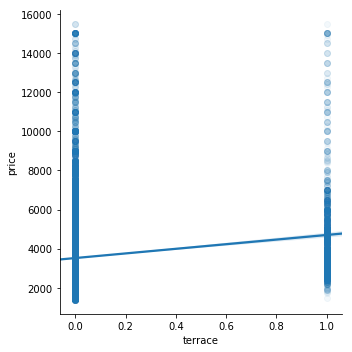

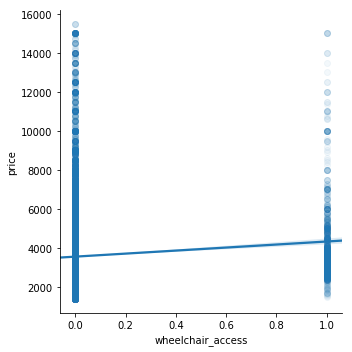

In [22]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='price', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

# Do Feature Selection

## Overview

The previous assignment quoted Wikipedia on [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering):

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Pedro Domingos says, "the most important factor is the **features used**."

This includes not just **Feature Engineering** (making new features, representing features in new ways) but also **Feature Selection** (choosing which features to include and which to exclude).

There are _many_ specific tools and techniques for feature selection.

- Today we'll try [scikit-learn's `SelectKBest` transformer](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), for "univariate, forward selection."
- Next week we'll try another technique, ["permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
- If you want to explore even more options, here are some good resources!
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.


My general recommendation is:

> Predictive accuracy on test sets is the criterion for how good the model is. — Leo Breiman, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)

In [23]:
# First, engineer some more features to select from

def engineer_features(df):
    # What's the neighborhood, based on address or latitude & longitude?
    clusters = pd.get_dummies(df['cluster'], prefix='cluster')
    for col in clusters:
        df[col] = clusters[col]
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

    
train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

((31844, 62), (16973, 61))

### Can we try every possible feature combination?
- https://en.wikipedia.org/wiki/Combination
- https://docs.python.org/3/library/itertools.html#itertools.combinations
- https://docs.python.org/3/library/math.html#math.factorial

In [24]:
# How many features do we have currently?
target = 'price'
features = train.columns.drop(target)
len(features)

61

In [25]:
# How many ways to choose 1 feature?
from itertools import combinations
len(list(combinations(features, 1)))

61

In [26]:
# How many ways to choose 2 features?
len(list(combinations(features, 2)))

1830

In [27]:
# How many ways to choose 3 features?
len(list(combinations(features, 3)))

35990

In [28]:
# How many ways to choose 1 to n features?

from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

total = 0
for k in range(1, len(features)+1):
    total += n_choose_k(len(features), k)
    
print(f'{total:,}')

2.3058430092136945e+18


## Follow Along

### Start simple & fast, with a subset of columns

Just numeric columns with no missing values

In [0]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

In [30]:
target = 'price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test = test_subset[features]
y_test = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 52), (31844,), (16973, 52), (16973,))

### Univariate, Forward selection
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [31]:
from sklearn.feature_selection import f_regression, SelectKBest

# SimilarAPI to what we've seen before
selector = SelectKBest(score_func=f_regression, k=10)

# Important
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape 

((31844, 10), (16973, 10))

In [32]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
bathrooms
bedrooms
longitude
doorman
dishwasher
fitness_center
laundry_in_unit
dining_room
perk_count
rooms

Features not selected:
latitude
elevator
cats_allowed
hardwood_floors
dogs_allowed
no_fee
laundry_in_building
pre-war
roof_deck
outdoor_space
high_speed_internet
balcony
swimming_pool
new_construction
terrace
exclusive
loft
garden_patio
wheelchair_access
common_outdoor_space
cluster
cluster_0
cluster_1
cluster_2
cluster_3
cluster_4
cluster_5
cluster_6
cluster_7
cluster_8
cluster_9
cluster_10
cluster_11
cluster_12
cluster_13
cluster_14
cluster_15
cluster_16
cluster_17
cluster_18
cluster_19
description_length


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $713


In [34]:
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $890 

2 features
Test MAE: $826 

3 features
Test MAE: $826 

4 features
Test MAE: $800 

5 features
Test MAE: $800 

6 features
Test MAE: $773 

7 features
Test MAE: $713 

8 features
Test MAE: $713 

9 features
Test MAE: $713 

10 features
Test MAE: $713 

11 features
Test MAE: $711 

12 features
Test MAE: $711 

13 features
Test MAE: $710 

14 features
Test MAE: $710 

15 features
Test MAE: $710 

16 features
Test MAE: $710 

17 features
Test MAE: $710 

18 features
Test MAE: $703 

19 features
Test MAE: $701 

20 features
Test MAE: $696 

21 features
Test MAE: $687 

22 features
Test MAE: $680 

23 features
Test MAE: $680 

24 features
Test MAE: $678 

25 features
Test MAE: $678 

26 features
Test MAE: $676 

27 features
Test MAE: $672 

28 features
Test MAE: $670 

29 features
Test MAE: $668 

30 features
Test MAE: $663 

31 features
Test MAE: $663 

32 features
Test MAE: $663 

33 features
Test MAE: $662 

34 features
Test MAE: $656 

35 features
Test MAE: $

# Do one-hot encoding of categorical features

## Follow Along

### Which features are non-numeric?

In [35]:
train.describe(exclude='number')

created description  ... cats_or_dogs cats_and_dogs
count                 31844       31844  ...        31844         31844
unique                31436       25710  ...            2             2
top     2016-05-14 01:11:03              ...        False         False
freq                      3        2033  ...        16627         17669
first   2016-04-01 22:12:41         NaN  ...          NaN           NaN
last    2016-05-31 23:10:48         NaN  ...          NaN           NaN

[6 rows x 9 columns]

In [36]:
# Notice that fitness center was a numeric encoding of a categorical feature
train['fitness_center'].value_counts()

0    23323
1     8521
Name: fitness_center, dtype: int64

In [0]:
binary_columns = ['has_description', 'cats_or_dogs', 'cats_and_dogs']
for col in binary_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

In [38]:
train[binary_columns].describe()

has_description  cats_or_dogs  cats_and_dogs
count     31844.000000  31844.000000   31844.000000
mean          0.936158      0.477861       0.445139
std           0.244476      0.499517       0.496989
min           0.000000      0.000000       0.000000
25%           1.000000      0.000000       0.000000
50%           1.000000      0.000000       0.000000
75%           1.000000      1.000000       1.000000
max           1.000000      1.000000       1.000000

### Check "cardinality" of non-numeric features

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

"One-hot encoding" adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

In [39]:
train.describe(exclude='number').T.sort_values(by='unique')

count unique  ...                first                 last
longitude_binned  31844      2  ...                  NaN                  NaN
interest_level    31844      3  ...                  NaN                  NaN
display_address   31775   6468  ...                  NaN                  NaN
street_address    31838  11280  ...                  NaN                  NaN
description       31844  25710  ...                  NaN                  NaN
created           31844  31436  ...  2016-04-01 22:12:41  2016-05-31 23:10:48

[6 rows x 6 columns]

### Explore `interest_level` feature

In [40]:
train['interest_level'].value_counts(normalize=True)

low       0.692532
medium    0.231786
high      0.075681
Name: interest_level, dtype: float64

In [41]:
train.groupby('interest_level')['price'].mean()

interest_level
high      2728.689212
low       3802.227633
medium    3175.026013
Name: price, dtype: float64

In [42]:
# Look at interest level for first 5 apartments
train['interest_level'].head()

0      high
1       low
2       low
3    medium
4       low
Name: interest_level, dtype: object

### Encode `interest_level` feature

In [43]:
# Look at interest level for first 5 apartments, one-hot encoded
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['interest_level'])
encoded.head()

interest_level_high  interest_level_low  interest_level_medium
0                    1                   0                      0
1                    0                   1                      0
2                    0                   1                      0
3                    0                   0                      1
4                    0                   1                      0

### Do one-hot encoding & Scale features, 
within a complete model fitting workflow.

#### Why and how to scale features before fitting linear models

Scikit-Learn User Guide, [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

> The `preprocessing` module further provides a utility class `StandardScaler` that implements the `Transformer` API to compute the mean and standard deviation on a training set. The scaler instance can then be used on new data to transform it the same way it did on the training set.

#### How to use encoders and scalers in scikit-learn
- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on the **validation / test** sets

In [0]:
from sklearn.preprocessing import StandardScaler

target = 'price'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')